In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import numpy as np
#Fork from https://tianchi.aliyun.com/notebook/464582?spm=a2c22.12281897.0.0.32f123b7UBX8BT
# 手动指定 PingFang 字体的路径
font_path = '/System/Library/Fonts/PingFang.ttc'
# 设置字体为 PingFang
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = FontProperties(fname=font_path).get_name()
# 设置字体为 PingFang
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = FontProperties(fname=font_path).get_name()
mpl.rcParams["axes.unicode_minus"] = False


In [143]:
#加载数据
data_user=pd.read_csv('/Users/shendingyu/PycharmProjects/pythonProject4/data.csv')
pd.concat([data_user.head(5), data_user.tail(5)])

,user_id,sku_id,behavior_type,cate_id,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11
3,98662432,320593836,1,6562,2014-12-06 10
4,98145908,290208520,1,13926,2014-12-16 21
12256901,93812622,378365755,1,11,2014-12-13 21
12256902,93812622,177724753,1,12311,2014-12-14 21
12256903,93812622,234391443,1,8765,2014-12-11 16
12256904,93812622,26452000,1,7951,2014-12-08 22
12256905,108404535,362699797,1,9847,2014-12-03 19


In [144]:
# 查看数据情况
print('数据大小为',len(data_user))
print('用户数量为：',len(set(data_user['user_id'])))
print('商品数量为：',len(set(data_user['sku_id'])))
print('商品品类为：',len(set(data_user['cate_id'])))

数据大小为 12256906
用户数量为： 10000
商品数量为： 2876947
商品品类为： 8916


由此可知本次分析的数据集包含了10000个用户在1个月内的的1200多万条购物行为数据，商品总数量超过287万，分布在8916个类目中。样本量足够大，可以支撑我们通过数据分析来完成结论洞察。

# 数据处理

In [145]:
# 查看数据缺失情况
data_user.isnull().sum()

user_id          0
sku_id           0
behavior_type    0
cate_id          0
time             0
dtype: int64

In [146]:
#查看重复值个数
data_user.duplicated().sum()

6043527

可以看出，共有604万多的重复值，需要删除重复值

In [147]:
#删除重复值
data_user=data_user.drop_duplicates(subset=['user_id','sku_id','behavior_type','cate_id','time'],keep='first')

In [148]:
# 重新查看数据情况
print('数据大小为',len(data_user))
print('用户数量为：',len(set(data_user['user_id'])))
print('商品数量为：',len(set(data_user['sku_id'])))
print('商品品类为：',len(set(data_user['cate_id'])))

数据大小为 6213379
用户数量为： 10000
商品数量为： 2876947
商品品类为： 8916


删除完重复行后，样本数量减少到了621万

In [149]:
# 分割天(date)和小时(hour)，方便后续做分析
data_user['date'] = data_user['time'].map(lambda x: x.split(' ')[0])
data_user['hour'] = data_user['time'].map(lambda x: x.split(' ')[1])
data_user.head()

,user_id,sku_id,behavior_type,cate_id,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21


In [150]:
# 查看字段类型：
data_user.dtypes

user_id           int64
sku_id            int64
behavior_type     int64
cate_id           int64
time             object
date             object
hour             object
dtype: object

In [151]:
#修改字段类型
data_user['user_id'] = data_user['user_id'].astype('object')
data_user['sku_id'] = data_user['sku_id'].astype('object')
data_user['cate_id'] = data_user['cate_id'].astype('object')
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['hour'] = data_user['hour'].astype('int64')

data_user.dtypes

user_id                  object
sku_id                   object
behavior_type             int64
cate_id                  object
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

# 数据分析 & 可视化

## Part1. 流量分析
### 1. 基于天级别访问流量分析

In [152]:
# 计算PV: PageView , UV: UniqueView
# PV: select count(user_id) from data_user group by "date";
# UV: select count(distinct(user_id)) from data_user group by "date";
pv_daily = data_user.groupby('date')['user_id'].count()
# pv_daily.head()
pv_daily = pv_daily.reset_index() 
pv_daily = pv_daily.rename(columns={'user_id':'pv_daily'})
pv_daily

,date,pv_daily
0,2014-11-18,186278
1,2014-11-19,181713
2,2014-11-20,178849
3,2014-11-21,168903
4,2014-11-22,183014
5,2014-11-23,194205
6,2014-11-24,191139
7,2014-11-25,186803
8,2014-11-26,183017
9,2014-11-27,188747


In [153]:
#按日期看不太明显，我们可以对这组数据排序
pv_daily2=pv_daily.sort_values(by='pv_daily',ascending=False,ignore_index=True)
pv_daily2

,date,pv_daily
0,2014-12-12,346464
1,2014-12-11,247364
2,2014-12-10,215171
3,2014-12-03,209477
4,2014-12-02,206313
5,2014-12-13,205983
6,2014-11-30,204398
7,2014-12-14,204056
8,2014-12-04,203829
9,2014-12-09,202261


排过序后，我们可以清晰的看到在数据集给的一个月中，12月12日访问量最多，因为双十二促销活动

In [154]:
# 计算UV
uv_daily = data_user.groupby('date')['user_id'].apply(lambda x: len(x.unique()))
uv_daily = uv_daily.reset_index()
uv_daily = uv_daily.rename(columns = {'user_id':'uv_daily'})
uv_daily

,date,uv_daily
0,2014-11-18,6343
1,2014-11-19,6420
2,2014-11-20,6333
3,2014-11-21,6276
4,2014-11-22,6187
5,2014-11-23,6373
6,2014-11-24,6513
7,2014-11-25,6351
8,2014-11-26,6357
9,2014-11-27,6359


In [155]:
#同样地，对UV进行排序
uv_daily2=uv_daily.sort_values(by='uv_daily',ascending=False,ignore_index=True)
uv_daily2

,date,uv_daily
0,2014-12-12,7720
1,2014-12-11,6894
2,2014-12-15,6787
3,2014-12-13,6776
4,2014-12-16,6729
5,2014-12-14,6668
6,2014-12-10,6652
7,2014-12-17,6643
8,2014-12-03,6585
9,2014-12-18,6582


可以明显看出来，12月12日用户独立访问量（访客量）也是数据集给的这一个月中最多的

Text(0.5, 1.0, 'uv_daily')

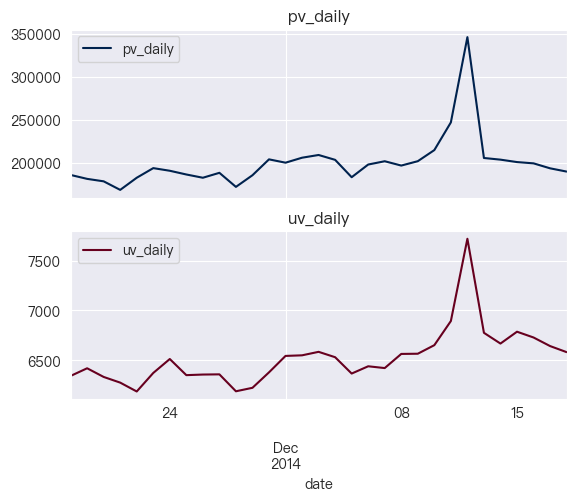

In [156]:
#可视化结果
fig,axes=plt.subplots(nrows=2,ncols=1,sharex=True)#共享x轴
pv_daily.plot(x='date',y='pv_daily',ax=axes[0],colormap='cividis')
uv_daily.plot(x='date',y='uv_daily',ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')

可以看出，不管是PV还是UV趋势，均在12号的时候出现了一个尖峰，这正是著名的双十二大促节的用户集中消费导致的变化。
通过简单的数据分析和可视化工具，这是我们从数据中观察到了第一个结论。

In [157]:
#总访问量
pv=data_user['user_id'].count() #6213379
print("总访问量为：{}".format(pv))
#总访客量
uv=data_user['user_id'].unique().size
print("总独立访问量（访客量）为：{}".format(uv))
#人均访问量
per_pv=pv/uv
print("人均访问量为：{:.2f}".format(per_pv))
#日均访问量
day_pv=pv/31  #样本中共有31天
print("日均访问量为：{:.2f}".format(day_pv))


总访问量为：6213379
总独立访问量（访客量）为：10000
人均访问量为：621.34
日均访问量为：200431.58


### 2. 基于小时级别访问流量分析

上面的对不同访问量进行分析，其分析的时间跨度是每天。另外从我们的直觉可以知道，用户在一天当中的使用也是有一定规律的。为了探索这个规律，我们将按照每小时统计用户的访问量和独立访问量。同pv_daily, uv_daily分析，我们完成如下代码：

In [158]:
# 计算每小时的PV
pv_hour = data_user.groupby('hour')['user_id'].count()
pv_hour = pv_hour.reset_index()
pv_hour = pv_hour.rename(columns={'user_id':'pv_hour'})
pv_hour

,hour,pv_hour
0,0,264993
1,1,138190
2,2,76170
3,3,51872
4,4,41865
5,5,45623
6,6,81224
7,7,146054
8,8,199962
9,9,244014


In [159]:
# 计算每小时UV
uv_hour = data_user.groupby('hour')['user_id'].apply(lambda x: len(x.unique()))
uv_hour = uv_hour.reset_index()
uv_hour = uv_hour.rename(columns={'user_id':'uv_hour'})
uv_hour

,hour,uv_hour
0,0,5786
1,1,3780
2,2,2532
3,3,1937
4,4,1765
5,5,2030
6,6,3564
7,7,5722
8,8,7108
9,9,7734


Text(0.5, 1.0, 'uv_hour')

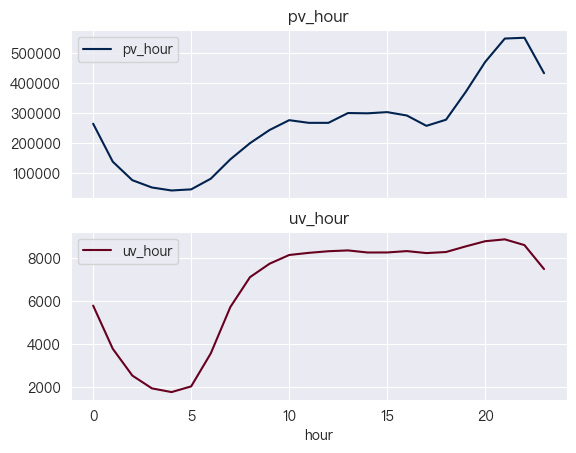

In [160]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')

从“日PV/UV”趋势看，双十二当天的总体流量会出现明显的峰值。那么双十二当天基于小时的用户访问数据会有变化吗？我们来写代码分析：

In [161]:
data_user_1212 = data_user.loc[data_user['date']=='2014-12-12']
data_user_1212

,user_id,sku_id,behavior_type,cate_id,time,date,hour
13,101260672,212072908,1,10984,2014-12-12 11,2014-12-12,11
20,101781721,19349307,1,1863,2014-12-12 12,2014-12-12,12
54,100684618,94486594,1,10984,2014-12-12 23,2014-12-12,23
69,103802946,190848347,1,5232,2014-12-12 22,2014-12-12,22
95,104811265,354843735,1,10585,2014-12-12 21,2014-12-12,21
...,...,...,...,...,...,...,...
12256013,56708793,106957130,1,8665,2014-12-12 08,2014-12-12,8
12256236,62126989,122790346,1,10431,2014-12-12 23,2014-12-12,23
12256532,76314785,245154832,2,2947,2014-12-12 00,2014-12-12,0
12256607,76314785,322071819,1,6648,2014-12-12 00,2014-12-12,0


In [162]:
data_user_1212.dtypes

user_id                  object
sku_id                   object
behavior_type             int64
cate_id                  object
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

In [163]:
# 计算每小时的PV
pv_hour_1212 = data_user_1212.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'1212_pv_hour'})
uv_hour_1212 = data_user_1212.groupby('hour')['user_id'].apply(lambda x: len(x.unique())).reset_index().rename(columns={'user_id':'1212_uv_hour'})
#pv_hour_1212
uv_hour_1212

,hour,1212_uv_hour
0,0,1569
1,1,811
2,2,411
3,3,255
4,4,211
5,5,264
6,6,679
7,7,1296
8,8,1712
9,9,1827


Text(0.5, 1.0, 'pv_hour_1212')

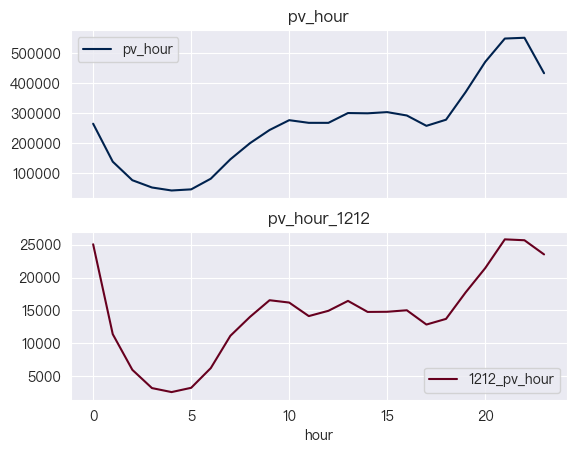

In [164]:
#为了对比分析，绘制一个月中每天某个时刻用户对淘宝的访问量和双十二某个时刻用户对淘宝的访问量
fig, axes = plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
pv_hour_1212.plot(x='hour', y='1212_pv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('pv_hour_1212')

Text(0.5, 1.0, 'uv_hour_1212')

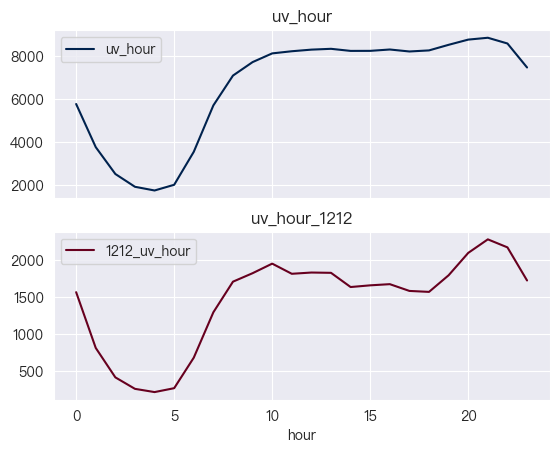

In [165]:
# 可视化 UV
fig, axes = plt.subplots(2,1,sharex=True)
uv_hour.plot(x='hour',y='uv_hour',ax=axes[0],colormap='cividis')
uv_hour_1212.plot(x='hour', y='1212_uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('uv_hour')
axes[1].set_title('uv_hour_1212')

可以看到，双十二当天，PV变化趋与一个月内的PV变化趋势基本一致。UV变化趋势稍有不同，可以看到双十二当天在晚上8点之后UV出现了小高峰，表明了大促当天用户的消费意愿比较强烈。

### 3. 不同用户行为流量分析

In [166]:
# 基于 behavior_type & hour 分组
# 点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示
pv_behavior = data_user.groupby(['behavior_type','hour'])['user_id'].count()
pv_behavior = pv_behavior.reset_index()
pv_behavior = pv_behavior.rename(columns={'user_id':'pv_behavior'})
pv_behavior

,behavior_type,hour,pv_behavior
0,1,0,235979
1,1,1,123931
2,1,2,68462
3,1,3,46794
4,1,4,37445
...,...,...,...
91,4,19,5693
92,4,20,7012
93,4,21,7873
94,4,22,7795


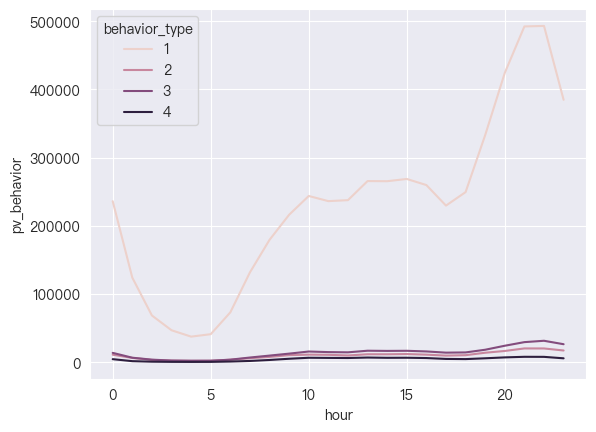

In [167]:
# 可视化
# sns: serborn
ax = sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior)

因为behavior_type为1（浏览行为）的占比非常大，导致上图其它几类behavior的趋势不太明显，我们去掉behavior_type为1的数据后再来看看：

<Axes: xlabel='hour', ylabel='pv_behavior'>

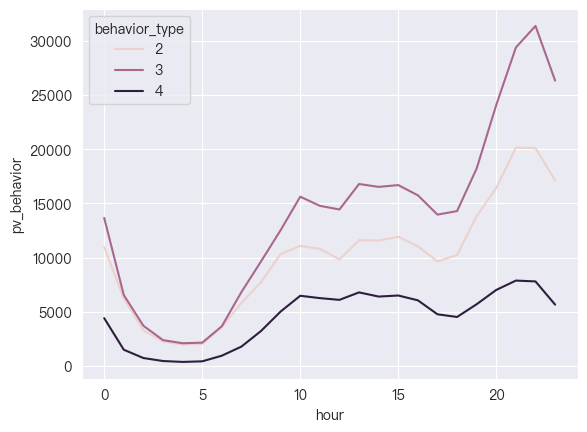

In [168]:
sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior[pv_behavior.behavior_type!=1])

可以看出4种行为按照小时的变化趋势基本一致，都是在晚上7点之后有明显增长，凌晨2-6点是低峰，符合常识。

对双十二当天对用户行为进行分析：

In [169]:
pv_behavior_1212 = data_user_1212.groupby(['behavior_type','hour'])['user_id'].count()
pv_behavior_1212 = pv_behavior_1212.reset_index()
pv_behavior_1212 = pv_behavior_1212.rename(columns={'user_id':'pv_behavior_1212'})
pv_behavior_1212

,behavior_type,hour,pv_behavior_1212
0,1,0,20466
1,1,1,9706
2,1,2,5120
3,1,3,2781
4,1,4,2231
...,...,...,...
91,4,19,500
92,4,20,583
93,4,21,771
94,4,22,896


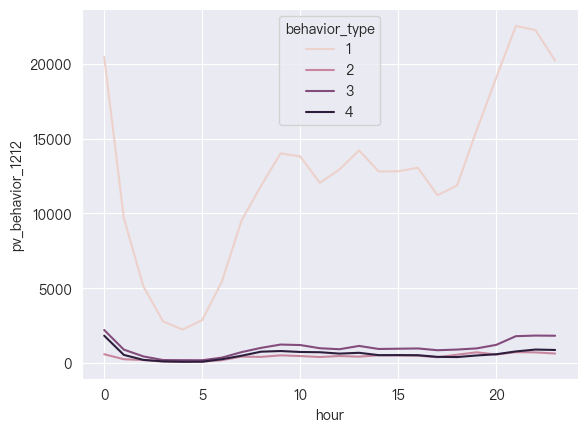

In [170]:
# 可视化
# sns: serborn
ax = sns.lineplot(x='hour',y='pv_behavior_1212',hue='behavior_type',data=pv_behavior_1212)

可以看出，双十二当天，凌晨点击量非常大，因为许多用户在活动刚开始时就来浏览和购物。这可能是由于限时抢购、优惠券等促销活动吸引了大量用户。

因为behavior_type为1（浏览行为）的占比非常大，导致上图其它几类behavior的趋势不太明显，我们去掉behavior_type为1的数据后再来看看：

<Axes: xlabel='hour', ylabel='pv_behavior_1212'>

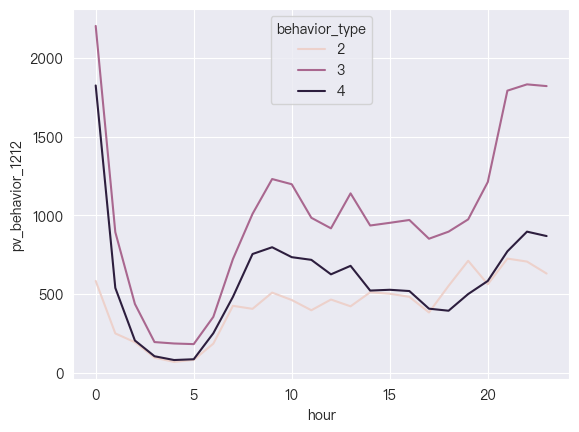

In [171]:
#点击、收藏、加购物车、支付 --1 2 3 4
sns.lineplot(x='hour',y='pv_behavior_1212',hue='behavior_type',data=pv_behavior_1212[pv_behavior_1212.behavior_type!=1])

在双十二当天，加购物车和支付这两种行为按照小时的变化趋势基本一致，而收藏这种行为按小时的的变化趋势与其他两种有点差异；双十二当天凌晨，用户支付量和加入购物车的数量比较大，可能是因为双十二当天很多电商平台会推出限时抢购和优惠促销等活动，而凌晨是一些抢购活动的开始时间，用户在这个时候会将心仪的商品加入购物车，并快速支付以确保能够抢到心仪的商品；收藏量比较少是比较正常的，因为双十二促销活动，用户更倾向于快速购买而不是将商品收藏。

对比分析一个月中每天某个时刻四种行为与双十二当天某个时刻四种行为的区别：双十二是否使用户某个行为增多？

Text(0.5, 1.0, 'pv_behavior_1212')

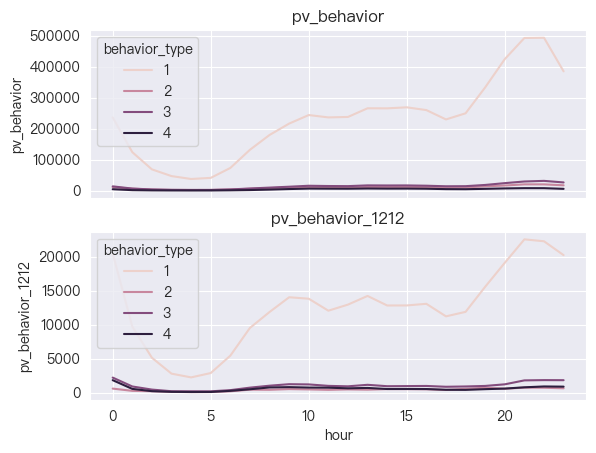

In [172]:
fig, axes = plt.subplots(2,1,sharex=True)
ax1 = sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior,ax=axes[0])
ax2 = sns.lineplot(x='hour',y='pv_behavior_1212',hue='behavior_type',data=pv_behavior_1212,ax=axes[1])
axes[0].set_title('pv_behavior')
axes[1].set_title('pv_behavior_1212')

Text(0.5, 1.0, 'pv_behavior_1212')

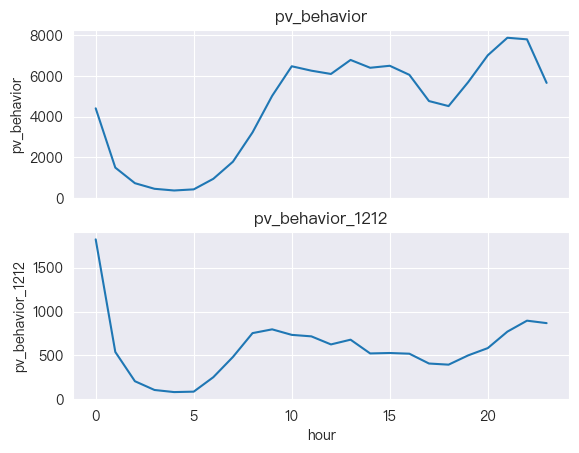

In [173]:
fig, axes = plt.subplots(2,1,sharex=True)
ax3 = sns.lineplot(x='hour',y='pv_behavior',data=pv_behavior[pv_behavior.behavior_type==4],ax=axes[0])
ax4 = sns.lineplot(x='hour',y='pv_behavior_1212',data=pv_behavior_1212[pv_behavior_1212.behavior_type==4],ax=axes[1])
axes[0].set_title('pv_behavior')
axes[1].set_title('pv_behavior_1212')

虽然双十二当天凌晨收藏量相比其他三种行为较少，但是双十二促销活动吸引了大量用户，使得凌晨收藏量比一个月平均每天凌晨收藏量高。

由此说明，电商平台应该多推出这种促销活动，可以吸引用户，促进商品销量。

## Part2. 转化率分析

我们来分析“浏览-收藏/加购-购买”链路的转化漏斗模型，可以帮助我们更好的了解各个环节的转化链路：

In [174]:
# 点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示
behavior_type = data_user.groupby(['behavior_type'])['user_id'].count()
behavior_type

behavior_type
1    5535879
2     239472
3     331350
4     106678
Name: user_id, dtype: int64

可以看到，用户浏览（behavior_type=1）的基数是最大的，因为加购和收藏没有必然联系，因此我们把这两类合并在一起做分析：

In [175]:
click_num, fav_num, add_num, pay_num =  behavior_type[1], behavior_type[2], behavior_type[3], behavior_type[4]

fav_add_num = fav_num + add_num 
print('点击 到 加购/收藏转化率：', 100 * fav_add_num / click_num)
print('点击 到 购买转化率: ', 100 * pay_num / click_num)
print('加购/收藏 到 购买转化率: ', 100 * pay_num / fav_add_num)
print('点击 到 收藏的转化率：',100 * fav_num /click_num)

点击 到 加购/收藏转化率： 10.311316414249662
点击 到 购买转化率:  1.927029113172452
加购/收藏 到 购买转化率:  18.688487829831367
点击 到 收藏的转化率： 4.325817092461739


可以观察到，从浏览到加购/收藏的转化率大约10%；"加购/收藏"后到购买转化率大约为18%，这个比例还是还是非常高的，说明用户感兴趣的商品更容易成单。
两者相乘，我们能粗略估出从浏览到购买的转化率约为2%左右。

In [176]:
#画漏斗图
import plotly.graph_objects as go

# 数据
data = [5535879, 570822, 106678]
phase = ['点击', '收藏/加购物车', '支付']

# 创建漏斗图
fig = go.Figure(go.Funnel(
    y = phase,
    x = data,
    textinfo = "value+percent initial"))

# 显示图表
fig.show()

可以看出，点击量到购买量的转化率大约为2%

### 1. 复购情况分析

In [177]:
# 计算用户购买频次
data_user_pay = data_user[data_user.behavior_type==4]
# 基于date去重，得到的结果即为购物分布的天数：
data_user_pay = data_user_pay.groupby('user_id')['date'].apply(lambda x: len(x.unique()))
data_user_pay

user_id
4913         5
6118         1
7528         6
7591         9
12645        4
            ..
142376113    1
142412247    7
142430177    5
142450275    8
142455899    7
Name: date, Length: 8886, dtype: int64

In [178]:
# 计算复购率：
repeat_buy_ratio = data_user_pay[data_user_pay > 1].count() / data_user_pay.count()
repeat_buy_ratio

0.8717083051991897

这批抽样数据在1个月内的复购率还是相当高的，达到了0.87。

### 2. 复购周期分析

In [179]:
data_user['action'] = 1 # 对每一行的行为记为1次，通过对行为次数的相加，从而计算频次
data_user_buy = data_user[data_user.behavior_type == 4]
data_user_buy = data_user_buy.groupby(['user_id','date'])['action'].count()
data_user_buy = data_user_buy.reset_index()
data_user_buy.head(30)

,user_id,date,action
0,4913,2014-12-01,1
1,4913,2014-12-07,1
2,4913,2014-12-11,1
3,4913,2014-12-13,1
4,4913,2014-12-16,1
5,6118,2014-12-17,1
6,7528,2014-11-22,1
7,7528,2014-11-26,1
8,7528,2014-11-27,1
9,7528,2014-11-30,1


In [180]:
# 对日期排序（按照先后顺序），给予pandas的date函数计算前后两次购物相差的天数，dropna去掉了每个用户在数据集周期内第一次购买日期的记录：
data_user_buy_date_diff = data_user_buy.groupby('user_id').date.apply(lambda x:x.sort_values().diff(1).dropna())

data_user_buy_date_diff.head(30)

user_id    
4913     1     6 days
         2     4 days
         3     2 days
         4     3 days
7528     7     4 days
         8     1 days
         9     3 days
         10    3 days
         11   10 days
7591     13    7 days
         14    1 days
         15    1 days
         16    2 days
         17    4 days
         18    1 days
         19    1 days
         20    1 days
12645    22    2 days
         23    4 days
         24   11 days
54056    26   19 days
79824    29    9 days
         30    8 days
         31    6 days
         32    1 days
         33    1 days
         34    3 days
88930    36    2 days
         37    2 days
         38    1 days
Name: date, dtype: timedelta64[ns]

Text(0, 0.5, 'count')

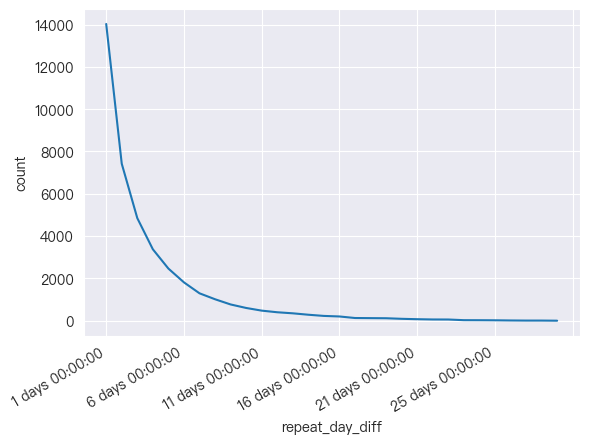

In [181]:
#可视化结果
data_user_buy_date_diff.value_counts().plot(kind='line')

plt.xlabel('repeat_day_diff')
plt.ylabel('count')

In [182]:
#上图中的横坐标有HH:MM:SS，我们只保留到days再重新绘制一下：
data_user_buy_date_diff = data_user_buy_date_diff.apply(lambda x:x.days)
data_user_buy_date_diff

user_id         
4913       1        6
           2        4
           3        2
           4        3
7528       7        4
                   ..
142455899  49196    2
           49197    2
           49198    4
           49199    3
           49200    1
Name: date, Length: 40315, dtype: int64

Text(0, 0.5, 'count')

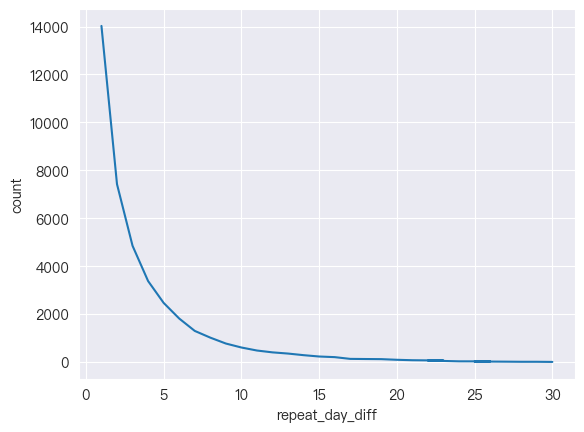

In [183]:
data_user_buy_date_diff.value_counts().plot(kind='line')
plt.xlabel('repeat_day_diff')
plt.ylabel('count')

可以看出，大部分用户的复购行为发生在5天之内，在第5天复购的行为出现了明显的拐点，如果这个时候采取营销策略提升用户的购买意图，可以增加更多收益。超过15天后，复购的意愿基本已经趋于0，此时可以考虑采取一些召回策略，增加复购的可能性，防止用户的流失。

# RFM模型

In [184]:
#最近一次消费距离现在的时间，我们计算用户最后一次消费的日期距离本样本中最后一天的日期即可，即2014-12-18
rfm=data_user[data_user['behavior_type']==4]
rfm=rfm.groupby('user_id')['date'].max()#最后一次的消费日期
rfm=rfm.reset_index()
rfm['internal']='2014-12-18'
rfm['internal']=pd.to_datetime(rfm['internal'])
rfm.dtypes
rfm['internal']=rfm['internal']-rfm['date'] #有单位不好计算，所以只取days,不要单位
rfm['internal']=rfm['internal'].dt.days
rfm

,user_id,date,internal
0,4913,2014-12-16,2
1,6118,2014-12-17,1
2,7528,2014-12-13,5
3,7591,2014-12-13,5
4,12645,2014-12-14,4
...,...,...,...
8881,142376113,2014-12-08,10
8882,142412247,2014-12-15,3
8883,142430177,2014-12-18,0
8884,142450275,2014-12-13,5


In [185]:
#最近一段时间的消费频次,前面已经计算过
rfm=pd.merge(rfm,data_user_pay,how='inner',on='user_id')
rfm.rename(columns={'date_y':'frequency'},inplace=True)
rfm

,user_id,date_x,internal,frequency
0,4913,2014-12-16,2,5
1,6118,2014-12-17,1,1
2,7528,2014-12-13,5,6
3,7591,2014-12-13,5,9
4,12645,2014-12-14,4,4
...,...,...,...,...
8881,142376113,2014-12-08,10,1
8882,142412247,2014-12-15,3,7
8883,142430177,2014-12-18,0,5
8884,142450275,2014-12-13,5,8


In [186]:
r_avg=rfm['internal'].mean()
f_avg=rfm['frequency'].mean()
print(r_avg)
print(f_avg)

5.811838847625478
5.53691199639883


In [187]:
#打分方式有很多种，这里我们选择比较简单的一种
#为每个用户打分,对于R，小于平均消费时间间隔的赋值为high，大于的赋值为low
#为每个用户打分,对于F，大于平均消费频次的赋值为high，小于的赋值为low
#本样本中没有给出金额数据，所以我们把客户分为4种
for i in range(len(rfm)):
    if(rfm.at[i,'internal']<r_avg):
        rfm.at[i,'R']='high'
    else:
        rfm.at[i,'R']='low'
    if(rfm.at[i,'frequency']>f_avg):
        rfm.at[i,'F']='high'
    else:
        rfm.at[i,'F']='low'
rfm

,user_id,date_x,internal,frequency,R,F
0,4913,2014-12-16,2,5,high,low
1,6118,2014-12-17,1,1,high,low
2,7528,2014-12-13,5,6,high,high
3,7591,2014-12-13,5,9,high,high
4,12645,2014-12-14,4,4,high,low
...,...,...,...,...,...,...
8881,142376113,2014-12-08,10,1,low,low
8882,142412247,2014-12-15,3,7,high,high
8883,142430177,2014-12-18,0,5,high,low
8884,142450275,2014-12-13,5,8,high,high


In [188]:
for i in range(len(rfm)):
    if((rfm.at[i,'R']=='high') and (rfm.at[i,'F']=='high')):
        rfm.at[i,'重要价值']='重要价值用户'
    elif((rfm.at[i,'R']=='high') and (rfm.at[i,'F']=='low')):
        rfm.at[i,'重要价值']='重要发展用户'
    elif((rfm.at[i,'R']=='low') and (rfm.at[i,'F']=='high')):
        rfm.at[i,'重要价值']='重要保持用户'
    elif((rfm.at[i,'R']=='low') and (rfm.at[i,'F']=='low')):
        rfm.at[i,'重要价值']='重要挽留用户'
rfm

,user_id,date_x,internal,frequency,R,F,重要价值
0,4913,2014-12-16,2,5,high,low,重要发展用户
1,6118,2014-12-17,1,1,high,low,重要发展用户
2,7528,2014-12-13,5,6,high,high,重要价值用户
3,7591,2014-12-13,5,9,high,high,重要价值用户
4,12645,2014-12-14,4,4,high,low,重要发展用户
...,...,...,...,...,...,...,...
8881,142376113,2014-12-08,10,1,low,low,重要挽留用户
8882,142412247,2014-12-15,3,7,high,high,重要价值用户
8883,142430177,2014-12-18,0,5,high,low,重要发展用户
8884,142450275,2014-12-13,5,8,high,high,重要价值用户


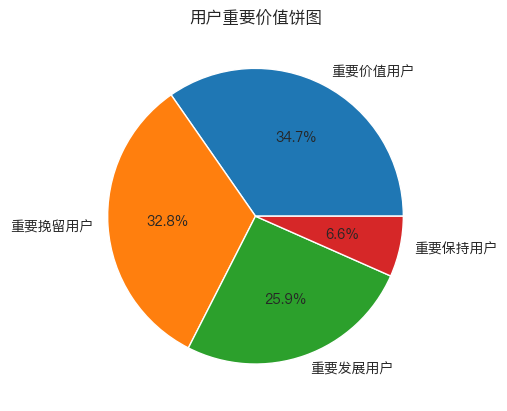

In [189]:
#可视化
plt.figure()
#plt.pie([rfm[rfm['重要价值']=='重要价值用户']['重要价值'].count(),rfm[rfm['重要价值']=='重要发展用户']['重要价值'].count(),rfm[rfm['重要价值']=='重要保持用户']['重要价值'].count(),rfm[rfm['重要价值']=='重要挽留用户']['重要价值'].count()],
#        labels=['重要价值用户','重要发展用户','重要保持用户','重要挽留用户'],autopct='%1.1f%%')
counts = rfm['重要价值'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('用户重要价值饼图')
plt.show()

用户忠诚度较低，有将近三分之一的用户是重要挽留客户

可以看出，重要价值用户是最多的，即购买时间间隔短，并且消费频次高的人数最多，这部分人群需要重点关注，可以给他们发放专属特别优惠，提升用户满意度；</br>
重要挽留用户，即消费时间间隔长，消费频次低的客户，这部分客户即将流失，要想办法挽留用户，可以给他们推送打折消息、优惠活动等等</br>
重要发展用户，需要提高他们的消费频次，可以在每次购物之后提供好评返现、限时优惠券等等，刺激他们下一次消费</br>
重要保持用户，消费频次高但是最近无消费，可以向这部分用户推送打折消息，发放优惠券等

可以看出，本次抽样中，重要挽留客户较多，需要重点关注